# Preprocess

This notebook will download and do the necessary preprocessing needed for the COCO Dataset

# Setup

## Imports

In [1]:
import magnet as mag

from magnet.utils.images import show_images

Running your code on a slow, boring CPU.
Make some money and buy yourself a GPU, will ya?

Pro Tip: If you're a poor old hag like me, use a cloud provider.


In [2]:
import torch

from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import CocoCaptions
from torchvision import transforms
from torchvision.models import resnet34

In [3]:
from types import MethodType

## HyperParameters

In [4]:
batch_size = 8
image_shape = 256

In [5]:
if type(image_shape) is int: image_shape = (image_shape, image_shape)

## Preparations

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
jtplot_style()

In [8]:
DIR_DATA = DIR_DATA.parent / 'COCO'

In [9]:
def download_and_extract(url, path, extract_path=None, extras=None):
    import wget, os

    from zipfile import ZipFile
    
    # Change to specified path (will make things convinient)
    path_cwd = os.getcwd()
    os.chdir(path)
    
    url = Path(url)
    filename = url.name
    
    if extract_path is not None and Path(extract_path).exists():
        return # Why bother. Job already done
    
    # Download if not yet done
    if not Path(filename).exists():
        print('Downloading...')
        wget.download(url)
    
    print('Extracting...')
    ZipFile(filename).extractall(extract_path) # Extract
    
    os.remove(filename) # Remove the zip file since it's no longer needed
    
    if extras is not None: extras()
        
    os.chdir(path_cwd) # Change back to working directory

In [10]:
def download_images(mode, path):
    download_and_extract(f'http://images.cocodataset.org/zips/{mode}2017.zip', path,
                         extract_path=mode)

In [11]:
def download_captions(path):
    if Path(DIR_DATA / 'train/captions.json').exists(): return # Why bother. Job already done
    
    def extras():
        import shutil
        
        for mode in ('train', 'val'):
            os.rename(f'annotations/captions_{mode}2017.json', f'{mode}/captions.json')
        shutil.rmtree('annotations')
    
    url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
    download_and_extract(url, path, extras=extras)

In [12]:
def show_coco(data):
    img, captions = data
    img = img[:4]; captions = captions[:4]
    
    captions = [c[np.random.randint(len(c))][:30] for c in captions]
    
    show_images(img.permute(0, 2, 3, 1).numpy().copy(), titles=captions, pixel_range='auto',
               merge=False)

## Load Data

Download and Extract Data

In [13]:
download_images('train', DIR_DATA)
download_images('val', DIR_DATA)

In [14]:
download_captions(DIR_DATA)

Take a look at the images

In [14]:
transform = transforms.Compose([transforms.Resize(image_shape), transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
dataset, data = {}, {}
for mode in ('train', 'val'):
    dataset[mode] = CocoCaptions(DIR_DATA / mode, DIR_DATA / mode / 'captions.json', transform)
    data[mode] = DataLoader(dataset[mode], batch_size)

loading annotations into memory...
Done (t=1.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


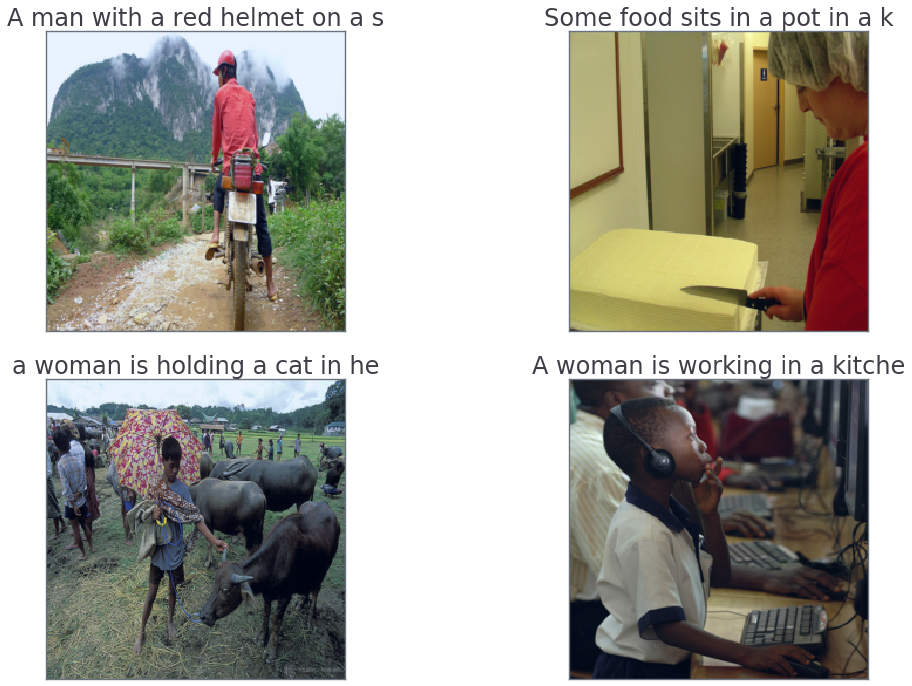

In [15]:
show_coco(next(iter(data['train'])))

# Extract Features

## Create Convolutional Extractor

In [16]:
extractor = resnet34().to(device)

In [17]:
del extractor.fc

In [18]:
def resnet34_forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)

    return x
    
extractor.forward = MethodType(resnet34_forward, extractor)

In [19]:
with mag.eval(extractor): 
    feature_size = len(extractor(next(iter(data['train']))[0][:1].to(device))[0])

## Extract

In [25]:
@mag.eval(extractor)
def get_features(mode):
    num_images = len(dataset[mode])
    features = torch.zeros(num_images, feature_size).to(device)
    
    for i, (x, _) in enumerate(tqdm(iter(data[mode]))):
        y = extractor(x.to(device))
        features[i * batch_size: min((i + 1) * batch_size, num_images)] = y
        
    return features

In [ ]:
for mode in ('train', 'val'):
    features = get_features(mode)
    torch.save(features.to('cpu'), DIR_NB / mode / 'features.pt')